In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from numba import njit

In [2]:
%config InlineBackend.figure_format = "retina"

In [3]:
n_rows = 7
n_cols = 10
gridworld = np.zeros((n_rows, n_cols))

In [4]:
init_pos = np.array([3, 0])
goal_pos = np.array([3, 7])

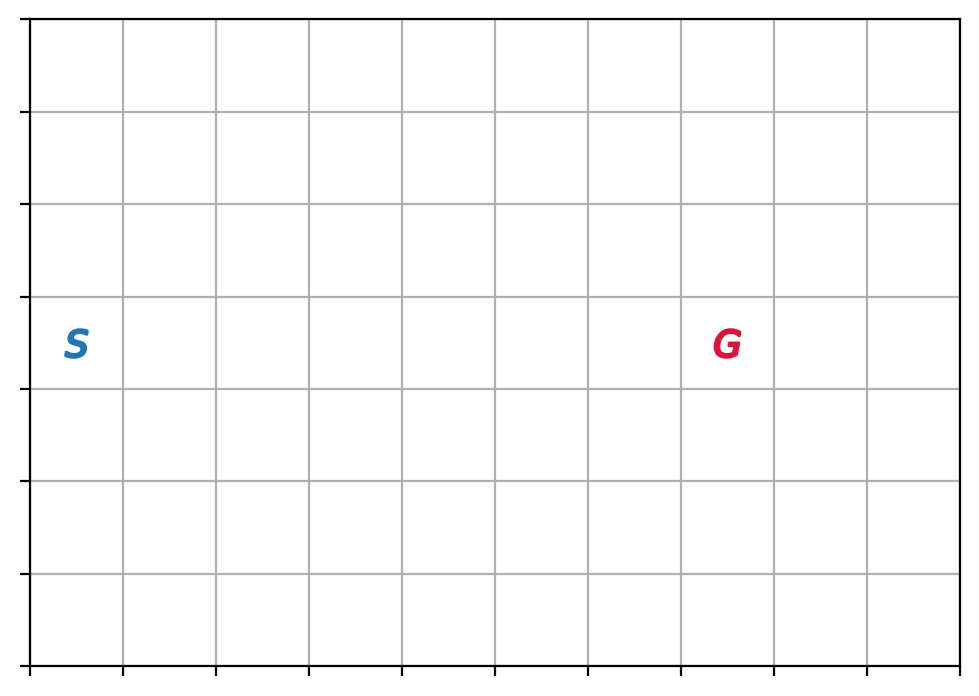

In [5]:
fig, ax = plt.subplots(figsize=(n_cols * 0.6, n_rows * 0.6))
xticks = np.arange(n_cols + 1)
yticks = np.arange(n_rows + 1)

init = init_pos[::-1] + 0.5
goal = goal_pos[::-1] + 0.5
ax.scatter(*init, marker="$S$", s=100)
ax.scatter(*goal, marker="$G$", s =100, c="crimson")
# plt.scatter(*finish_pos)

ax.set_xticks(xticks, labels="")
plt.yticks(yticks, labels="")


plt.grid()

In [6]:
movements = np.array([
    [0, 1], # right
    [0, -1], # left
    [1, 0], # down,
    [-1, 0], # up
    # [0, 0], # nothing
])
n_actions = len(movements)

name_movements = ["right", "left", "down", "up"]
# name_movements = ["right", "left", "down", "up", "nothing"]

In [7]:
@njit
def get_probas(qval, epsilon):
    qmax = qval.max()
    n_actions = len(qval)
    mask = qmax == qval

    if np.all(mask):
        probas = np.ones(n_actions) / n_actions
    elif sum(mask) > 1:
        n_equal = sum(mask)
        probas = epsilon * np.ones(n_actions) /  n_actions
        probas = ((1 - epsilon) / n_actions + epsilon) * mask +  probas * (1 - mask)
    else:
        # return epsilon-greeedy action
        action_max = qval.argmax()
        probas = epsilon * np.ones(n_actions) / n_actions
        probas[action_max] = 1 - epsilon + epsilon / n_actions

    return probas

## Another gridworld

In [8]:
n_rows = 7
n_cols = 10
ixs = np.arange(n_rows * n_cols).reshape(n_rows, n_cols)
ixs

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
       [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
       [60, 61, 62, 63, 64, 65, 66, 67, 68, 69]])

In [9]:
@njit
def get_pos(ix, n_cols):
    row = ix // n_cols
    col = ix % n_cols
    pos = np.array([row, col])
    return pos


@njit
def get_ix(pos, n_cols):
    row, col = pos
    ix = row * n_cols + col
    return ix


@njit
def move_pos(pos, step, n_rows, n_cols):
    row, col = pos
    row_next, col_next = pos + step
    
    if (row_next < 0) or (row_next >= n_rows):
        row_next = row
    if (col_next < 0) or (col_next >= n_cols):
        col_next = col
    
    pos_next = np.array([row_next, col_next])
    return pos_next


@njit
def choose_action(ix, Q, epsilon):
    probas = get_probas(Q[ix], epsilon)
    action = np.random.multinomial(1, probas).argmax()
    return action


@njit
def move_and_reward(
    ix, step, n_rows, n_cols, start_state, end_state, reward_goal, move_fn
):
    ix_new = move_fn(ix, step, n_rows, n_cols) # new s

    reward = -1 if ix != end_state else reward_goal
    ix_new = ix_new if ix != end_state else start_state
    
    return ix_new, reward


@njit
def sarsa_step(
    s, a, Q, epsilon, n_rows, n_cols, start_state, end_state, reward_goal, move_fn
):
    # (s, a) -> (r, s_new, a_new)
    step = movements[a]
    s_new, r = move_and_reward(s, step, n_rows, n_cols, start_state, end_state, reward_goal, move_fn)
    a_new = choose_action(s_new, Q, epsilon)

    return r, s_new, a_new

In [10]:
@njit
def move(ix, step, n_rows, n_cols):
    pos = get_pos(ix, n_cols)
    pos_new = move_pos(pos, step, n_rows, n_cols)
    ix_new = get_ix(pos_new, n_cols)
    return ix_new
    

@njit
def wind_strength(n_row, n_col):
    c_strength = 0
    
    # s = np.random.uniform() > 1/3
    if n_col in [3, 4, 5, 8]:
        r_strength = -1 
    elif n_col in [6, 7]:
        r_strength = -2 
    elif n_col in [1]: # optional
        r_strength = 2
    else:
        r_strength = 0

    move_wind = np.array([r_strength, c_strength])
    return move_wind


@njit
def move_wind(ix, step, n_rows, n_cols):
    pos = get_pos(ix, n_cols)
    row, col = pos
    wind_shift = wind_strength(row, col)
    pos_new = move_pos(pos, step + wind_shift, n_rows, n_cols)
    
    ix_new = get_ix(pos_new, n_cols)
    return ix_new

In [11]:
%%time
Q = np.zeros((n_rows * n_cols, n_actions)) # action-value function

epsilon = 0.01
alpha = 0.5
gamma = 1.0
start_state = 30
end_state =  37 #69

reward_goal = 20

ix = start_state
action = choose_action(ix, Q, epsilon)
ix_hist = [start_state]
action_hist = [action]
reward_hist = [0]

# np.random.seed(314)
for _ in range(5000):
    r, ix_new, action_new = sarsa_step(ix, action, Q, epsilon, n_rows, n_cols, start_state, end_state, reward_goal, move_wind)
    # SARSA update
    Q[ix, action] = Q[ix, action] + alpha * (r + gamma * Q[ix_new, action_new] - Q[ix, action])
    ix, action = ix_new, action_new

    action_hist.append(action)
    ix_hist.append(ix)
    reward_hist.append(r)

action_hist = np.array(action_hist)
ix_hist = np.array(ix_hist)
reward_hist = np.array(reward_hist)

CPU times: user 3.24 s, sys: 322 ms, total: 3.56 s
Wall time: 3.56 s


In [12]:
reward_hist[-1000:].mean()

-0.328

In [13]:
ixs

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
       [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
       [60, 61, 62, 63, 64, 65, 66, 67, 68, 69]])

In [15]:
ix_goal = np.where(reward_hist == reward_goal)[0]
pos_hist = np.c_[ix_hist % n_cols, ix_hist // n_cols]
distance_hist = np.abs(pos_hist - get_pos(end_state, n_cols)).sum(axis=1)

In [16]:
markers = {
    "down": "v",
    "up": "^",
    "right": ">",
    "left": "<",
    "nothing": "o"
}

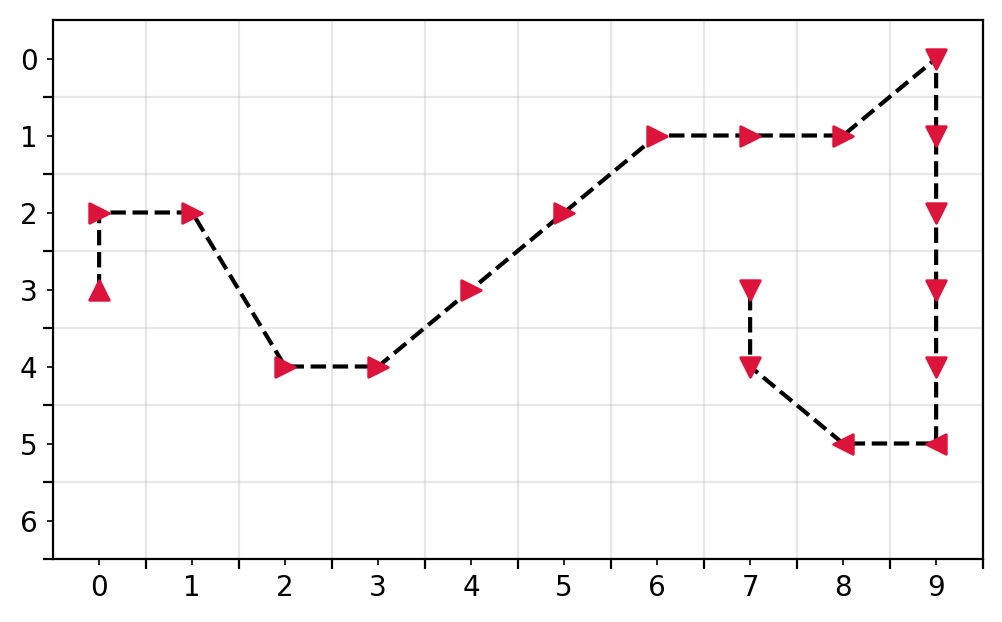

In [17]:
run = -2
iinit = ix_goal[run]
iend = ix_goal[run + 1]

subhist_action = action_hist[iinit:iend]
subhist_action = [name_movements[a] for a in subhist_action]
subhist_action = [markers[action] for action in subhist_action]

subhist_pos = pos_hist[iinit:iend]

fig, ax = plt.subplots(figsize=(n_cols * 0.6, n_rows * 0.5))
plt.plot(*subhist_pos.T, c="black", linestyle="--")

for (x,y), m in zip(subhist_pos, subhist_action):
    plt.scatter(x, y, marker=m, zorder=3, s=50, c="crimson")

xticks = np.arange(n_cols)
yticks = np.arange(n_rows)
ax.set(
    xticks=xticks + 0.5,
    yticks=yticks + 0.5,
    xticklabels="",
    yticklabels="",
)
ax.set_xticks(xticks, labels=xticks, minor=True)
ax.set_yticks(yticks, labels=yticks, minor=True)

# ax.scatter(*pos_hist[iinit], marker="$S$", s=100, zorder=3)
# ax.scatter(*pos_hist[iend-1], marker="$G$", s =100, c="crimson", zorder=3)
ax.set_ylim(-0.5, n_rows - 0.5)
ax.set_xlim(-0.5, n_cols - 0.5)
ax.invert_yaxis()

plt.grid(alpha=0.3)
plt.savefig("windy-gridworld.png", bbox_inches="tight", dpi=150)

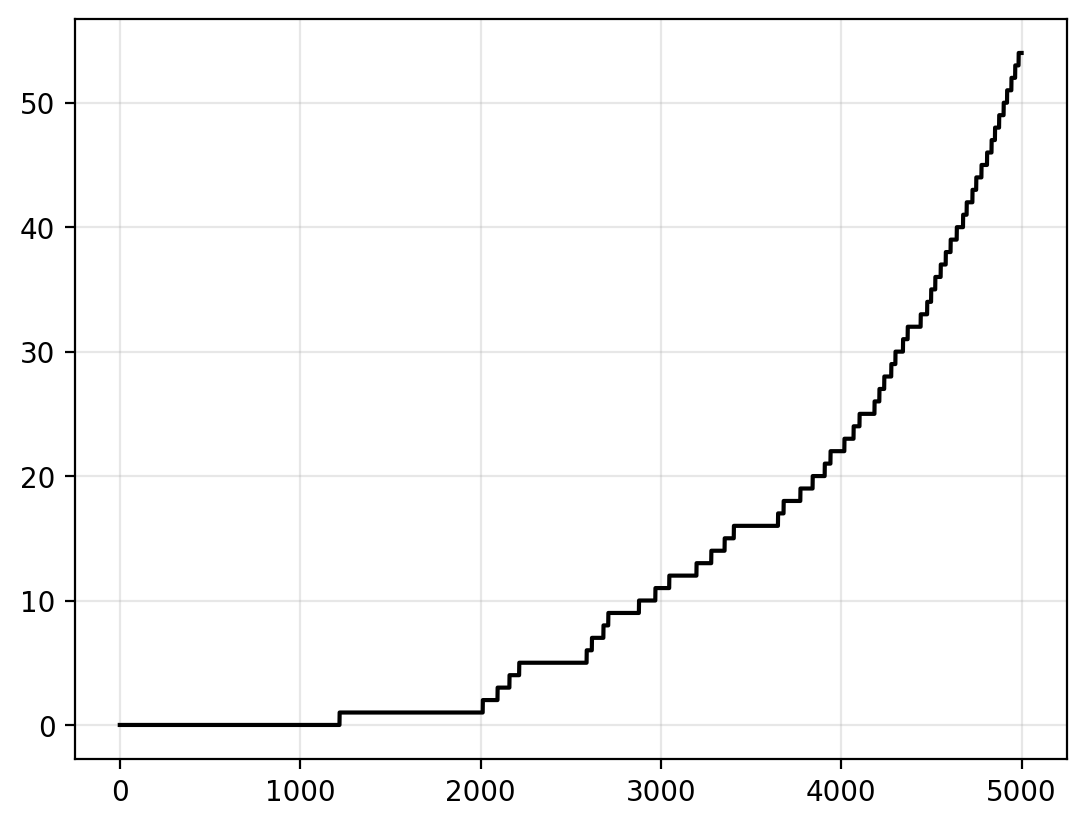

In [18]:
plt.plot((reward_hist == reward_goal).cumsum(), c="black")
plt.grid(alpha=0.3)